In [1]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import time
import random
from itertools import product
from joblib import Parallel, delayed

from tqdm import tqdm
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils.metric import distance_metric, type_metric


### Метод генетического алгоритма


In [92]:
class GeneticNeighbour:
    def __init__(self, data, k, population_size=30, generations=100, mutation_rate=0.3, patience=5):
        self.data = data
        self.k = k
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.patience = patience
        self.history = []
        self._elapsed_time = None
        self.result_iteration = None

    def get_result_iteration(self):
        return self.result_iteration

    def get_result_fitness(self):
        return min(self.history)

    def get_elapsed_time(self):
        return self._elapsed_time

    def initialize_population(self):
        return [self.data[np.random.choice(len(self.data), self.k, replace=False)]
                for _ in range(self.population_size)]

    def assign_clusters(self, centroids):
        distances = np.linalg.norm(self.data[:, np.newaxis] - centroids, axis=2)
        return np.argmin(distances, axis=1)

    def fitness(self, centroids):
        cluster_assignments = self.assign_clusters(centroids)
        clusters = [[] for _ in range(self.k)]
        for point, cluster_id in zip(self.data, cluster_assignments):
            clusters[cluster_id].append(point)

        sse = 0
        for cluster in clusters:
            if cluster:
                cluster = np.array(cluster)
                min_dist_sum = float('inf')
                best_medoid = None
                for p in cluster:
                    dist_sum = np.sum(np.linalg.norm(cluster - p, axis=1) ** 2)
                    if dist_sum < min_dist_sum:
                        min_dist_sum = dist_sum
                        best_medoid = p
                sse += np.sum((cluster - best_medoid) ** 2)

        empty_clusters = sum(1 for cluster in clusters if len(cluster) == 0)
        penalty = empty_clusters * 1e6

        return 1 / (sse + penalty + 1e-6)

    def crossover(self, parent1, parent2):
        idx = np.random.randint(1, self.k)
        child = np.vstack((parent1[:idx], parent2[idx:]))
        return child

    def mutate(self, centroids):
        if np.random.rand() < self.mutation_rate:
            num_mutations = np.random.randint(1, self.k // 2 + 1)
            mutation_indices = np.random.choice(self.k, num_mutations, replace=False)
            for idx in mutation_indices:
                centroids[idx] = self.data[np.random.randint(len(self.data))]
        return centroids

    def evolve(self):
        population = self.initialize_population()
        best_solution = None
        best_score = -np.inf
        stagnation = 0

        start_time = time.time()

        for generation in range(self.generations):
            scored = [(c, self.fitness(c)) for c in population]
            scored.sort(key=lambda x: x[1], reverse=True)
            best_current = scored[0][1]
            self.history.append(best_current)

            if best_current > best_score + 1e-6:
                best_score = best_current
                best_solution = scored[0][0]
                stagnation = 0
            else:
                stagnation += 1

            if stagnation >= self.patience:
                self.result_iteration = generation
                break

            top_parents = [c for c, _ in scored[:self.population_size // 2]]
            elites = [c for c, _ in scored[:2]]

            children = elites.copy()
            while len(children) < self.population_size:
                p1, p2 = random.sample(top_parents, 2)
                child = self.crossover(p1, p2)
                child = self.mutate(child)
                children.append(child)

            self.result_iteration = generation
            population = children

        self._elapsed_time = time.time() - start_time
        return best_solution

    def plot_history(self):
        min_fitness = min(self.history)
        plt.figure(figsize=(8, 4))
        plt.plot(([min_fitness/h for h in self.history]))
        plt.title("Прогресс фитнес-функции по поколениям")
        plt.xlabel("Поколение")
        plt.ylabel("Фитнес (SSE)")
        plt.grid(True)
        plt.show()

    def plot_result(self, centroids):
        cluster_assignments = self.assign_clusters(centroids)
        for i in range(self.k):
            cluster_points = self.data[cluster_assignments == i]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Кластер {i}")
        plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Центроиды')
        plt.title("Результат кластеризации (GA Neighbour — K-Medoids)")
        plt.legend()
        plt.grid(True)
        plt.show()

### Библиотечный метод

In [40]:
class KMedoidsWrapper:
    def __init__(self, data, k):
        self.data = data.tolist()
        self.k = k
        self._elapsed_time = None
        self.medoids = None
        self.clusters = None
        self.inertia = None

    def evolve(self):

        initial_medoids = random.sample(range(len(self.data)), self.k)

        model = kmedoids(self.data, initial_medoids, metric=distance_metric(type_metric.EUCLIDEAN))
        start_time = time.time()
        model.process()
        self._elapsed_time = time.time() - start_time  + 0.001
        self.clusters = model.get_clusters()
        self.medoids = [self.data[i] for i in model.get_medoids()]

        sse = 0
        for i, cluster in enumerate(self.clusters):
            for point_index in cluster:
                point = np.array(self.data[point_index])
                center = np.array(self.medoids[i])
                sse += np.sum((point - center) ** 2)
        self.inertia = sse
        return np.array(self.medoids)

    def get_result_fitness(self):
        return 1 / (self.inertia + 1e-6)

    def get_elapsed_time(self):
        return self._elapsed_time

    def plot_result(self, centroids):
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
        for i, cluster in enumerate(self.clusters):
            cluster_points = np.array([self.data[j] for j in cluster])
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i % len(colors)], label=f"Кластер {i}")
        plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Медоиды')
        plt.title("Кластеризация Pyclustering K-Medoids")
        plt.legend()
        plt.grid(True)
        plt.show()


### Метод полного перебора

In [35]:
class BruteForceNeighbour:
    def __init__(self, data, k):
        self.data = data
        self.k = k
        self.best_assignment = None
        self.best_centroids = None
        self.min_sse = float('inf')
        self.history = []
        self._elapsed_time = None

    def get_result_iteration(self):
        return len(self.history)

    def get_result_fitness(self):
        return min(self.history)

    def get_elapsed_time(self):
        return self._elapsed_time

    def get_best_centroids(self):
        return self.best_centroids

    def _sse_and_centroids(self, assignments):
        centroids = []
        sse = 0
        for cluster_id in range(self.k):
            cluster_points = self.data[np.array(assignments) == cluster_id]
            if len(cluster_points) == 0:
                return float('inf'), None

            min_dist_sum = float('inf')
            best_medoid = None
            for point in cluster_points:
                dist_sum = np.sum(np.linalg.norm(cluster_points - point, axis=1) ** 2)
                if dist_sum < min_dist_sum:
                    min_dist_sum = dist_sum
                    best_medoid = point
            centroids.append(best_medoid)

            for point in cluster_points:
                sse += np.sum((point - best_medoid) ** 2)

        return sse, np.array(centroids)

    def evolve(self):
        all_assignments = itertools.product(range(self.k), repeat=len(self.data))
        start_time = time.time()

        for assignment in all_assignments:
            current_sse, centroids = self._sse_and_centroids(assignment)
            self.history.append(current_sse)
            if current_sse < self.min_sse:
                self.min_sse = current_sse
                self.best_assignment = assignment
                self.best_centroids = centroids

        self._elapsed_time = time.time() - start_time
        return self.best_assignment

    def plot_history(self):
        plt.plot(self.history)
        plt.xlabel("Итерация")
        plt.ylabel("SSE")
        plt.title("История изменения SSE (Brute Force)")
        plt.grid()
        plt.show()

    def plot_result(self):
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
        for cluster_id in range(self.k):
            cluster_points = self.data[np.array(self.best_assignment) == cluster_id]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                        color=colors[cluster_id % len(colors)], label=f'Кластер {cluster_id}')
        if self.best_centroids is not None:
            plt.scatter(self.best_centroids[:, 0], self.best_centroids[:, 1],
                        color='black', marker='x', s=100, label='Центроиды')
        plt.title("Оптимальное разбиение (Brute Force Medoid)")
        plt.legend()
        plt.grid()
        plt.show()

In [70]:
np.random.seed(33)
data = np.random.rand(2000, 2)
K = 2

### Инициализация

In [93]:
ga_neighbour = GeneticNeighbour(data, k=K, generations=50)

In [7]:
bf_neighbour = BruteForceNeighbour(data, k=K)

In [56]:
km_neighbour = KMedoidsWrapper(data, k=K)

### Эволюция

In [94]:
ga_best_centroids = ga_neighbour.evolve()

In [10]:
bf_best_centroids = bf_neighbour.evolve()

In [58]:
km_best_centroids = km_neighbour.evolve()

### График эволюционирования

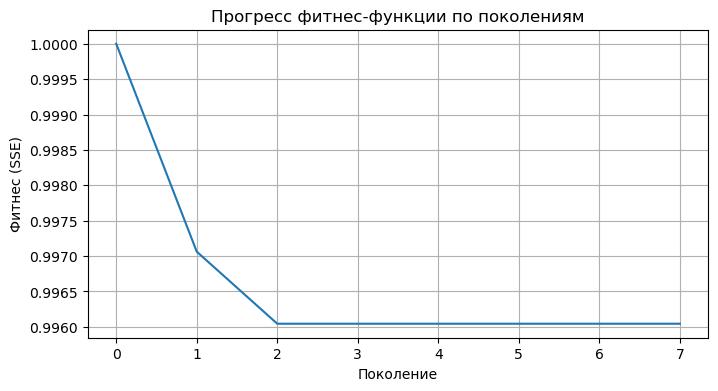

In [95]:
ga_neighbour.plot_history()

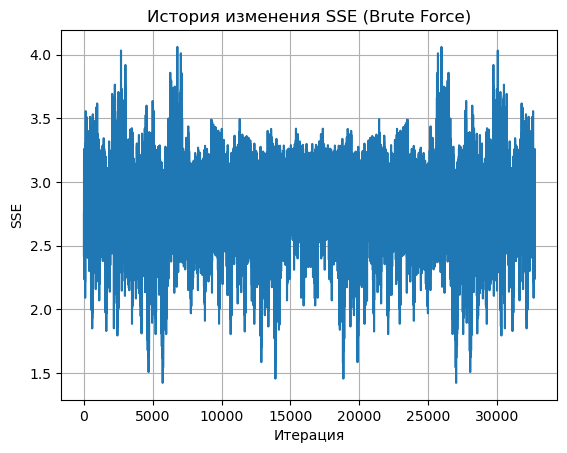

In [51]:
bf_neighbour.plot_history()

### Результирующий график

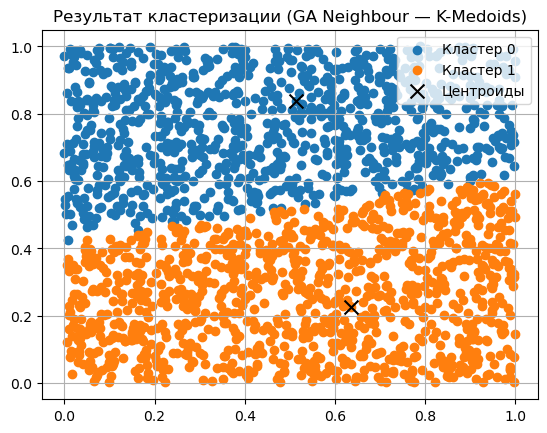

In [79]:
ga_neighbour.plot_result(ga_best_centroids)

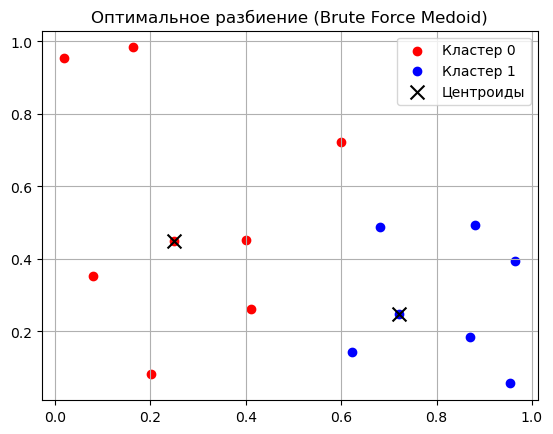

In [61]:
bf_neighbour.plot_result()

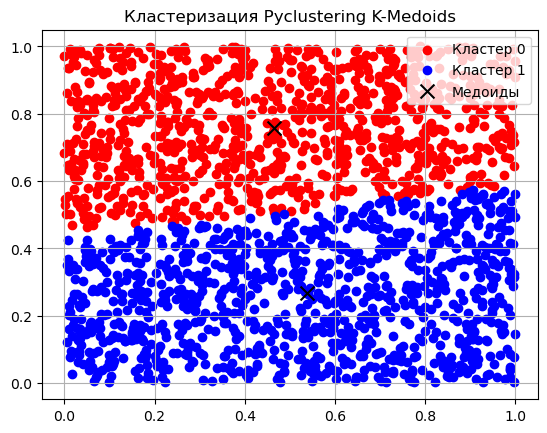

In [62]:
km_neighbour.plot_result(km_best_centroids)

In [80]:
print(f"---------Result of Genetic Alg fitness---------\n SSE: {ga_neighbour.get_result_fitness():.3f}\n Time: {ga_neighbour.get_elapsed_time():.3f} s.\n Iterations:{ga_neighbour.get_result_iteration()}")
print(f"---------Result Brute Force fitness------------\n SSE: {bf_neighbour.get_result_fitness():.3f}. \n Time: {bf_neighbour.get_elapsed_time():.3f} s.\n Iterations {bf_neighbour.get_result_iteration()}")
print(f"---------Library fitness------------\n SSE: {km_neighbour.get_result_fitness():.3f}. \n Time: {km_neighbour.get_elapsed_time()} s.")
print("------------------------------------------------")

---------Result of Genetic Alg fitness---------
 SSE: 0.005
 Time: 10.930 s.
 Iterations:5
---------Result Brute Force fitness------------
 SSE: 1.421. 
 Time: 8.849 s.
 Iterations 32768
---------Library fitness------------
 SSE: 0.005. 
 Time: 1.3264263401031493 s.
------------------------------------------------


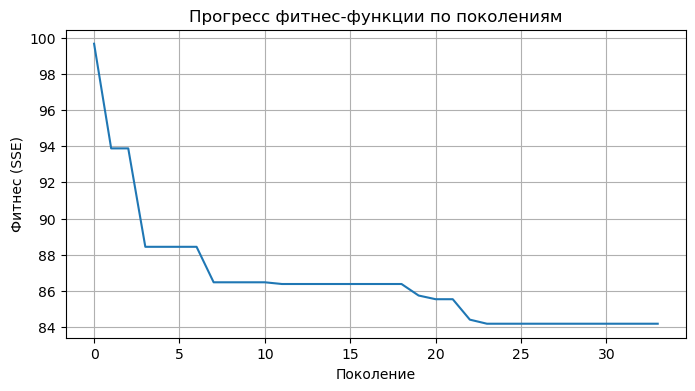

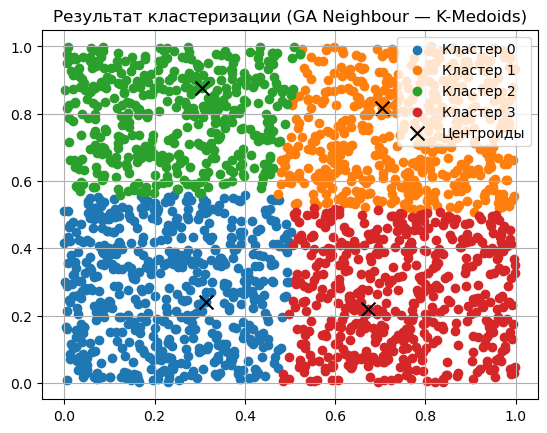

---------Result of Genetic Alg fitness:---------
 SSE: 0.010033885049454426.
 Time: 43.58593201637268 s.
 Iterations:33.


In [18]:
np.random.seed(42)
data = np.random.rand(2000, 2)
K = 4
ga1_neighbour = GeneticNeighbour(data, k=K, population_size=30, generations=100, mutation_rate=0.3, patience=10)
ga1_best_centroids = ga1_neighbour.evolve()
ga1_neighbour.plot_history()
ga1_neighbour.plot_result(ga1_best_centroids)
print(f"---------Result of Genetic Alg fitness:---------\n SSE: {ga1_neighbour.get_result_fitness()}.\n Time: {ga1_neighbour.get_elapsed_time()} s.\n Iterations:{ga1_neighbour.get_result_iteration()}.")

## Подбор гиперпараметров методом RandomSearch

In [19]:
def evaluate_params(data, k, params):
    model = GeneticNeighbour(
        data=data,
        k=k,
        population_size=params['population_size'],
        generations=params['generations'],
        mutation_rate=params['mutation_rate'],
        patience=params['patience']
    )
    centroids = model.evolve()
    score = model.get_result_fitness()
    return score, params, model


def randomized_search(data, k, param_grid, n_iter=10, n_jobs=-1):
    keys, values = zip(*param_grid.items())
    sampled_combinations = [dict(zip(keys, v)) for v in random.sample(list(product(*values)), n_iter)]

    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_params)(data, k, params) for params in tqdm(sampled_combinations, desc="Randomized Search")
    )

    best_result = max(results, key=lambda x: x[0])
    return best_result[2], best_result[1], best_result[0]

In [20]:
data = np.random.rand(2000, 2)
K = 4
param_grid = {
    'population_size': [10, 20, 30, 40],
    'generations': [50, 100, 150],
    'mutation_rate': [0.2, 0.3, 0.5],
    'patience': [5, 10, 15]
}

Randomized Search: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


Лучшая комбинация параметров: {'population_size': 20, 'generations': 100, 'mutation_rate': 0.3, 'patience': 15}
Лучший fitness: 0.01180680609178542
Время лучшей модели: 56.86815881729126


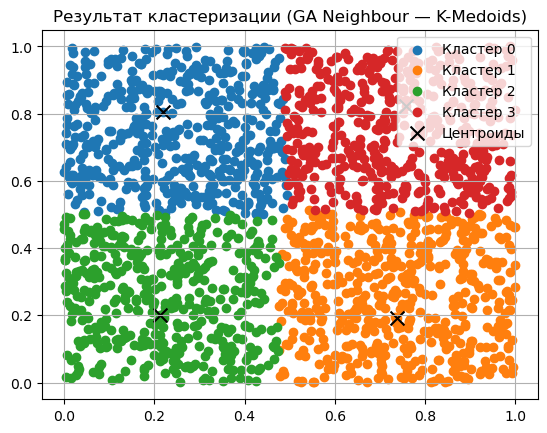

In [21]:
best_model, best_params, best_score = randomized_search(
    data=data,
    k=4,
    param_grid=param_grid,
    n_iter=12,
    n_jobs=6
)

print("Лучшая комбинация параметров:", best_params)
print("Лучший fitness:", best_score)
print("Время лучшей модели:", best_model.get_elapsed_time())

# Отрисовка результатов
centroids = best_model.evolve()
best_model.plot_result(centroids)

KMedoids фитнес: 0.012122028287779254
Время KMedoids: 1.5768945217132568


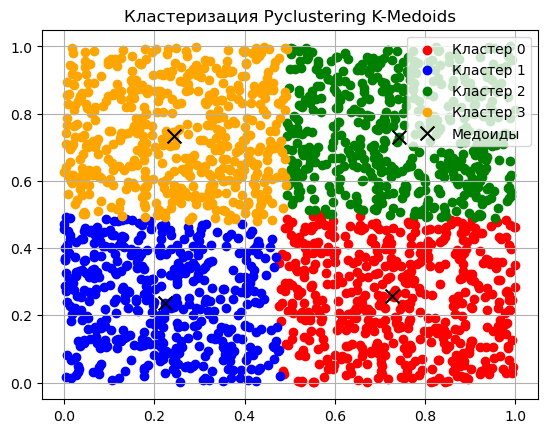

In [22]:
km1_model = KMedoidsWrapper(data, 4)
centroids1 = km1_model.evolve()
print("KMedoids фитнес:", km1_model.get_result_fitness())
print("Время KMedoids:", km1_model.get_elapsed_time())
km1_model.plot_result(centroids1)

## Описание задачи

Задача кластеризации — это разбиение множества точек в пространстве на `k` кластеров так, чтобы точки в одном кластере были как можно ближе к его центру. Основной критерий качества — `SSE` (сумма квадратов расстояний от точек до их центроидов). Чем меньше SSE, тем лучше разбиение.

---

## Область применения

Задача ближайший соседей является задачей кластеризации и поэтому может использоваться в различных прикладных задачах, например:
маркетинг, биоинформатика, языковые модели и обработка текстов, обработка изображений.

---
Сложность генетического алгоритма состовляет:

$O(P \cdot G \cdot n \cdot k)$

где:
- `n` — количество точек
- `k` — количество кластеров
- `P` — размер популяции
- `G` — число поколений

Что гараздо эффективнее в сравнении со сложностью полного перебора:

$O(k^n)$

---

## Выводы

- Brute Force — полезен только для малых наборов данных, где возможен полный перебор.
- Genetic Algorithm — универсальное решение, дающее хорошие приближённые результаты при разумной настройке.
- Library - стабильно даёт хорошее SSE и работает быстро. Лучшее решения для поставленной задачи

| (n, k)     | Время (сек)   | Итерации | SSE    | NormSSE | Алгоритм    |
|------------|---------------|----------|--------|---------|-------------|
| (15, 2)    | 0.012         | 8        | 0.704  | 0.088   | GenAlg      |
| (15, 2)    | 8.849         | 32768    | 0.692  | 0.086   | BruteForce  |
| (15, 2)    | 0.000         | —        | 0.692  | 0.086   | Library     |
| (20, 2)    | 0.062         | 13       | 2.13   | 0.106   | GenAlg      |
| (20, 2)    | 362.039       | 1048576  | 1.86   | 0.093   | BruteForce  |
| (20, 2)    | 0.001         | —        | 1.93   | 0.096   | Library     |
| (200, 4)   | 0.831         | 24       | 18.73  | 0.102   | GenAlg      |
| (200, 4)   | —             | —        | —      | —       | BruteForce  |
| (200, 4)   | 0.031         | -        | 12.15  | 0.066   | Library     |
| (2000, 4)  | 6.402         | 35       | 153.28 | 0.089   | GenAlg      |
| (2000, 4)  | —             | —        | —      | —       | BruteForce  |
| (2000, 4)  | 0.184         | -        | 113.67 | 0.066   | Library     |
| (200, 10)  | 1.104         | 28       | 26.59  | 0.097   | GenAlg      |
| (200, 10)  | —             | —        | —      | —       | BruteForce  |
| (200, 10)  | 0.046         | -        | 21.81  | 0.079   | Library     |
| (2000, 10) | 9.867         | 42       | 211.03 | 0.087   | GenAlg      |
| (2000, 10) | —             | —        | —      | —       | BruteForce  |
| (2000, 10) | 0.302         | -        | 173.94 | 0.071   | Library     |
| (10000, 2) | 18.191        | 31       | 789.55 | 0.081   | GenAlg      |
| (10000, 2) | —             | —        | —      | —       | BruteForce  |
| (10000, 2) | 1.132         | -        | 650.21 | 0.066   | Library     |
